## Train language models for computing perplexity (meause how much a source text dataset and a target differ)

We'll use a GPT-2 model from Hugging Face with a custom tokenizer, will should be at a character level. 

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

import sys
sys.path.append("..") # Adds higher directory to python modules path.

from src.data.htr_datamodule import HTRDataModule
from src.data.htr_datamodule import HTRDataset

import torch
from torchvision.transforms import v2
import torchvision

import src



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:14: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to 

In [114]:
# # Import GPT-2

# model = AutoModelForCausalLM.from_pretrained("gpt2")

In [115]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(94, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=94, bias=False)
)


In [2]:
# from transformers import AutoTokenizer, GPT2Model, GPT2Config

from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config

# tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
config = GPT2Config(
  vocab_size=94,
  bos_token_id=0,
  eos_token_id=1, 
  n_positions=1024,
  n_layers=4,
  n_head=4,
  n_embd=128,
  dropout=0.4,
)
model = GPT2LMHeadModel(config)
print(model)


# Print number of parameters
print(model.num_parameters()) # 85.9M


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(94, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=94, bias=False)
)
2522624


In [3]:
# Instantiate manually the datasets
tokenizer = src.data.components.tokenizers.CharTokenizer(model_name="char_tokenizer", vocab_file="../data/vocab.txt")

# IAM dataset
with open("../data/htr_datasets/IAM/splits/train.txt", "r") as f:
  setfiles = f.read().splitlines()
  
read_data = src.data.data_utils.read_data_IAM
images_paths, words = read_data("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", setfiles)
htr_dataset = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))

VOCAB SIZE TOKENIZER: 94
COMPLETE VOCAB: {'[BOS]': 0, '[EOS]': 1, '[PAD]': 2, '[UNK]': 3, ' ': 4, '!': 5, '"': 6, '#': 7, '%': 8, '&': 9, "'": 10, '(': 11, ')': 12, '*': 13, '+': 14, ',': 15, '-': 16, '.': 17, '/': 18, '0': 19, '1': 20, '2': 21, '3': 22, '4': 23, '5': 24, '6': 25, '7': 26, '8': 27, '9': 28, ':': 29, ';': 30, '<': 31, '=': 32, '>': 33, '?': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, ']': 62, '_': 63, 'a': 64, 'b': 65, 'c': 66, 'd': 67, 'e': 68, 'f': 69, 'g': 70, 'h': 71, 'i': 72, 'j': 73, 'k': 74, 'l': 75, 'm': 76, 'n': 77, 'o': 78, 'p': 79, 'q': 80, 'r': 81, 's': 82, 't': 83, 'u': 84, 'v': 85, 'w': 86, 'x': 87, 'y': 88, 'z': 89, '{': 90, '}': 91, '£': 92, '€': 93}


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [35]:
# Generic functions for reading data and create a dataloader

def read_dataset(images_path, sequences_path, split_path, read_data, tokenizer, batch_size, transform=v2.Compose([v2.ToTensor()])):
  with open(split_path, "r") as f:
    setfiles = f.read().splitlines()
  
  images_paths, words = read_data(images_path, sequences_path, setfiles)
  htr_dataset = HTRDataset(images_paths, words, binarize=True, transform=transform)

  # Create dataloader for iam
  dl = torch.utils.data.DataLoader(
    htr_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True,
    collate_fn=lambda batch: src.data.data_utils.collate_fn(
      batch,
      img_size=(128,1024), # Warning, for debugging purposes
      text_transform=tokenizer.prepare_text
    )
  )
  return dl

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [40]:
dl_train = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/train.txt", src.data.data_utils.read_data_IAM, tokenizer, batch_size=4,
                        transform=v2.Compose(
                          [
                            torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.ElasticTransform(5.0, 5.0)], p=0.5),
                            torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.RandomAffine(degrees=1, translate=(0.01, 0.05), shear=[-1, 1, -1, 1], fill=255)], p=0.5),
                            torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.RandomPerspective(distortion_scale=0.1, p=1.0, fill=255)], p=0.5),
                            torchvision.transforms.v2.ToTensor()
                          ]))
dl_val = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/val.txt", src.data.data_utils.read_data_IAM, tokenizer, batch_size=4,
                      transform=v2.Compose([v2.ToTensor()]))

In [37]:
# Get a batch from dl_train

images, targets, _ = next(iter(dl_train))

print(targets.transpose(0,1))

for seq in targets.transpose(0,1):
  seq = seq.numpy().tolist()
  print(tokenizer.detokenize(seq))



tensor([[ 0, 65, 81, 78, 84, 70, 71, 83,  4, 83, 78,  4, 71, 72, 82,  4, 77, 78,
         83, 72, 66, 68, 17,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 72, 77, 82, 68, 77, 82, 72, 83, 72, 85, 68, 75, 88,  4, 79, 84, 82,
         71, 72, 77, 70, 15,  4, 47, 72, 82, 82,  4, 53, 71, 68, 72, 75, 64,  4,
         35, 75, 75, 68, 77,  1,  2,  2,  2,  2],
        [ 0, 68, 69, 69, 72, 66, 72, 68, 77, 66, 88,  4, 64, 77, 67, 15,  4, 72,
         77,  4, 83, 71, 68,  4, 66, 64, 82, 68,  4, 78, 69,  4, 47, 81, 17,  4,
         52, 72, 66, 71, 64, 81, 67, 82, 15,  1],
        [ 0, 82, 84, 65, 82, 83, 64, 77, 83, 72, 64, 75, 75, 88,  4, 71, 72, 70,
         71, 68, 81,  4, 75, 64, 82, 83,  4, 88, 68, 64, 81,  4, 83, 71, 64, 77,
          4, 72, 77,  4, 20, 28, 24, 28, 17,  1]])
brought to his notice.
insensitively pushing, Miss Sheila Allen
efficiency and, in the case of Mr. Richards,
substantially higher last year than in 195

In [7]:
# Pass a sequence to the model for training

print(targets.shape)
outputs = model(targets)
print(outputs.logits.shape)



torch.Size([42, 4])
torch.Size([42, 4, 94])


In [155]:
# Train the model to iterate over the dataset and train the model

# Train the model
from tqdm import tqdm

dl_train = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/train.txt", src.data.data_utils.read_data_IAM, tokenizer, batch_size=16,
                        transform=v2.Compose([v2.ToTensor()]))
dl_val = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/val.txt", src.data.data_utils.read_data_IAM, tokenizer, batch_size=16,
                      transform=v2.Compose([v2.ToTensor()]))

criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.to("cuda")

# Reinitialize the weights of the model randomly
# def weights_init(m):
#   if isinstance(m, torch.nn.Linear):
#     torch.nn.init.xavier_normal_(m.weight)
#     torch.nn.init.zeros_(m.bias)

def generate(model, tokenizer, num_sequences, max_length=100):
  model.eval()
  
  sequences = torch.ones(num_sequences, 1).long().to("cuda") * tokenizer.bos_id
  first_k_tokens_prob = model(sequences).logits[:, -1].topk(num_sequences)
  # print(f'Sequences shape: {sequences.shape}')
  # print(f'First k tokens prob: {first_k_tokens_prob.indices[0]}')
  
  sequences = torch.cat([sequences, first_k_tokens_prob.indices[0].unsqueeze(0).transpose(1,0)], dim=-1)
  
  # print(f'First sequences: {sequences}')
  
  with torch.no_grad():
    for i in range(max_length):
      outputs = model(sequences).logits
      next_token = outputs[:, -1].argmax(-1)
      # Get the num_sequences most probable next tokens
      sequences = torch.cat([sequences, next_token.unsqueeze(-1)], dim=-1)
      
  return sequences
      
      
generated_output = generate(model, tokenizer, 2, max_length=100)
print(f'generated_output: {generated_output}')

for seq in generated_output:
  seq = seq.cpu().numpy().tolist()
  print(tokenizer.detokenize(seq))
  

def train_lm(train_dl, eval_dl, epochs):
  for epoch in range(epochs):
    model.train()
    total_loss_train, total_ppl_train = 0.0, 0.0
    for i, batch in enumerate(tqdm(train_dl)):
      images, targets = batch[0], batch[1]
      images = images.to("cuda")
      targets = targets.to("cuda")
      targets = targets.permute(1,0)
      labels = targets[:, 1:].clone().contiguous()
      # print(targets.shape, labels.shape)
      outputs = model(targets).logits
      outputs = outputs[:, :-1].contiguous()

      # For trianing debugging
      # for j, (label, out) in enumerate(zip(labels, outputs)):
      #     # print(f'out: {out}')
      #     out = out.argmax(-1)
      #     out_dec = tokenizer.detokenize(out.detach().cpu().numpy().tolist())
      #     label_dec = tokenizer.detokenize(label.detach().cpu().numpy().tolist())
      #     # print(f'Train: Label: {label_dec}===output:{out_dec}')
          
      loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
      total_loss_train += loss.item()
      total_ppl_train += torch.exp(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # if i % 100 == 0:
      #   print(f"Epoch {epoch}, Loss: {loss.item()}")
      
    print(f"Epoch {epoch}, Loss: {total_loss_train/len(train_dl)}. Perplexity: {total_ppl_train/len(train_dl)}")
        
    # Evaluate
    model.eval()
    with torch.no_grad():
      # Write in a output/eval.txt file
      with open("../outputs/eval.txt", "a") as f:
        f.write(f"Epoch {epoch}\n")
        
      total_ppl = 0.0
      for i, batch in enumerate(eval_dl):
        images, targets = batch[0], batch[1]
        images = images.to("cuda")
        targets = targets.to("cuda")
        targets = targets.permute(1,0)
        labels = targets[:, 1:].clone().contiguous()
        outputs = model(targets).logits
        outputs = outputs[:, :-1].contiguous()
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
        # loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
        # print(f'Perplexity: {torch.exp(loss)}')
        total_ppl += torch.exp(loss)
        
        with open("../outputs/eval.txt", "a") as f:
          f.write(f'Perplexity: {torch.exp(loss)}\n')
        for j, (label, out) in enumerate(zip(labels, outputs)):
          # print(f'out: {out}')
          out = out.argmax(-1)
          out_dec = tokenizer.detokenize(out.detach().cpu().numpy().tolist())
          label_dec = tokenizer.detokenize(label.detach().cpu().numpy().tolist())
          # print(out_dec)
          # Write in a ../outputs/eval.txt file
          with open("../outputs/eval.txt", "a") as f:
            f.write(f'Label: {label_dec}===output:{out_dec}\n')
            
          if i == 10:
            break

      print(f"Epoch {epoch}, Perplexity: {total_ppl/len(eval_dl)}")
      
      with open("../outputs/eval.txt", "a") as f:
        f.write(f"Epoch {epoch}, Perplexity: {total_ppl/len(eval_dl)}\n\n\n")
        
      
train_lm(dl_train, dl_val, 100)


generated_output: tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 22, 22, 22, 22, 22, 22, 22,
         22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
         22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
        [ 0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 71, 71, 71, 71, 71, 71, 71, 71, 71,
         71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71,
         71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71]], device='cuda:0')
3333333333333333333333333333333333333


100%|██████████| 406/406 [00:24<00:00, 16.72it/s]

Epoch 0, Loss: 2.9561867203031267. Perplexity: 20.712846755981445


Epoch 0, Perplexity: 14.191028594970703


100%|██████████| 406/406 [00:21<00:00, 18.53it/s]

Epoch 1, Loss: 2.5523153707898896. Perplexity: 12.865593910217285


Epoch 1, Perplexity: 12.09753131866455


100%|██████████| 406/406 [00:27<00:00, 14.80it/s]

Epoch 2, Loss: 2.4161495939264155. Perplexity: 11.225293159484863


Epoch 2, Perplexity: 10.70159912109375


100%|██████████| 406/406 [00:25<00:00, 15.94it/s]

Epoch 3, Loss: 2.3089663682900037. Perplexity: 10.085822105407715


Epoch 3, Perplexity: 9.826714515686035


100%|██████████| 406/406 [00:22<00:00, 17.71it/s]

Epoch 4, Loss: 2.2287606905246604. Perplexity: 9.309048652648926


Epoch 4, Perplexity: 9.243459701538086


100%|██████████| 406/406 [00:19<00:00, 20.60it/s]

Epoch 5, Loss: 2.1630666802082157. Perplexity: 8.716052055358887


Epoch 5, Perplexity: 8.767358779907227


100%|██████████| 406/406 [00:18<00:00, 22.51it/s]

Epoch 6, Loss: 2.108605570981068. Perplexity: 8.254182815551758


Epoch 6, Perplexity: 8.443750381469727


100%|██████████| 406/406 [00:27<00:00, 14.78it/s]

Epoch 7, Loss: 2.0592104933532003. Perplexity: 7.856718063354492


Epoch 7, Perplexity: 8.18464469909668


100%|██████████| 406/406 [00:23<00:00, 17.02it/s]

Epoch 8, Loss: 2.013619153076792. Perplexity: 7.507370948791504


Epoch 8, Perplexity: 7.998437881469727


100%|██████████| 406/406 [00:24<00:00, 16.29it/s]

Epoch 9, Loss: 1.9722777572758678. Perplexity: 7.2042317390441895


Epoch 9, Perplexity: 7.800201416015625


100%|██████████| 406/406 [00:20<00:00, 19.51it/s]

Epoch 10, Loss: 1.9339860665974358. Perplexity: 6.936417579650879


Epoch 10, Perplexity: 7.6798248291015625


100%|██████████| 406/406 [00:15<00:00, 25.91it/s]

Epoch 11, Loss: 1.9001127167288305. Perplexity: 6.7054057121276855


Epoch 11, Perplexity: 7.594366073608398


100%|██████████| 406/406 [00:28<00:00, 14.17it/s]

Epoch 12, Loss: 1.8652320953425516. Perplexity: 6.4797468185424805


Epoch 12, Perplexity: 7.43540620803833


100%|██████████| 406/406 [00:24<00:00, 16.28it/s]

Epoch 13, Loss: 1.8350238753069799. Perplexity: 6.281497001647949


Epoch 13, Perplexity: 7.373400688171387


100%|██████████| 406/406 [00:25<00:00, 15.99it/s]

Epoch 14, Loss: 1.806905423479127. Perplexity: 6.110630035400391


Epoch 14, Perplexity: 7.222459316253662


100%|██████████| 406/406 [00:27<00:00, 14.93it/s]

Epoch 15, Loss: 1.777012249225466. Perplexity: 5.932583332061768


Epoch 15, Perplexity: 7.171804428100586


100%|██████████| 406/406 [00:16<00:00, 25.25it/s]

Epoch 16, Loss: 1.7515383210088231. Perplexity: 5.785363674163818


Epoch 16, Perplexity: 7.130556583404541


100%|██████████| 406/406 [00:28<00:00, 14.01it/s]

Epoch 17, Loss: 1.7249711103040009. Perplexity: 5.632403373718262


Epoch 17, Perplexity: 7.068100452423096


100%|██████████| 406/406 [00:25<00:00, 16.04it/s]

Epoch 18, Loss: 1.701616244069461. Perplexity: 5.501633644104004


Epoch 18, Perplexity: 6.955383777618408


100%|██████████| 406/406 [00:23<00:00, 17.15it/s]

Epoch 19, Loss: 1.6785806126782459. Perplexity: 5.377406597137451


Epoch 19, Perplexity: 6.962108612060547


100%|██████████| 406/406 [00:26<00:00, 15.47it/s]

Epoch 20, Loss: 1.6561433646479264. Perplexity: 5.25954532623291


Epoch 20, Perplexity: 6.873007774353027


100%|██████████| 406/406 [00:16<00:00, 24.46it/s]

Epoch 21, Loss: 1.636376610236802. Perplexity: 5.1596999168396


Epoch 21, Perplexity: 6.9594573974609375


100%|██████████| 406/406 [00:21<00:00, 18.72it/s]

Epoch 22, Loss: 1.6134605936228936. Perplexity: 5.044503688812256


Epoch 22, Perplexity: 6.8333306312561035


100%|██████████| 406/406 [00:17<00:00, 23.49it/s]

Epoch 23, Loss: 1.5931941664277627. Perplexity: 4.94016695022583


Epoch 23, Perplexity: 6.8889360427856445


100%|██████████| 406/406 [00:25<00:00, 15.63it/s]

Epoch 24, Loss: 1.5769376402418014. Perplexity: 4.862651348114014


Epoch 24, Perplexity: 6.872344017028809


100%|██████████| 406/406 [00:23<00:00, 17.65it/s]

Epoch 25, Loss: 1.5564291089626368. Perplexity: 4.762004375457764


Epoch 25, Perplexity: 6.879155158996582


100%|██████████| 406/406 [00:27<00:00, 14.51it/s]

Epoch 26, Loss: 1.5382934045321837. Perplexity: 4.678928375244141


Epoch 26, Perplexity: 6.890265941619873


100%|██████████| 406/406 [00:25<00:00, 15.75it/s]

Epoch 27, Loss: 1.522401033951144. Perplexity: 4.607947826385498


Epoch 27, Perplexity: 6.911620140075684


100%|██████████| 406/406 [00:18<00:00, 22.14it/s]

Epoch 28, Loss: 1.50383670165621. Perplexity: 4.5237908363342285


Epoch 28, Perplexity: 6.888314723968506


100%|██████████| 406/406 [00:18<00:00, 21.54it/s]

Epoch 29, Loss: 1.488563416626653. Perplexity: 4.4520392417907715


Epoch 29, Perplexity: 6.746181488037109


100%|██████████| 406/406 [00:22<00:00, 18.21it/s]

Epoch 30, Loss: 1.470814667899033. Perplexity: 4.377157688140869


Epoch 30, Perplexity: 6.82507848739624


100%|██████████| 406/406 [00:29<00:00, 13.89it/s]

Epoch 31, Loss: 1.457991955902776. Perplexity: 4.321950912475586


Epoch 31, Perplexity: 6.784969806671143


100%|██████████| 406/406 [00:25<00:00, 16.03it/s]

Epoch 32, Loss: 1.4419375608120057. Perplexity: 4.250251770019531


Epoch 32, Perplexity: 6.749531269073486


100%|██████████| 406/406 [00:25<00:00, 16.14it/s]

Epoch 33, Loss: 1.428145604180585. Perplexity: 4.196100234985352


Epoch 33, Perplexity: 6.756870746612549


100%|██████████| 406/406 [00:19<00:00, 20.55it/s]

Epoch 34, Loss: 1.4106588751224463. Perplexity: 4.123600482940674


Epoch 34, Perplexity: 6.672250747680664


100%|██████████| 406/406 [00:17<00:00, 22.87it/s]

Epoch 35, Loss: 1.398298422984889. Perplexity: 4.071597099304199


Epoch 35, Perplexity: 6.819494724273682


100%|██████████| 406/406 [00:28<00:00, 14.00it/s]

Epoch 36, Loss: 1.3861809447774747. Perplexity: 4.025391101837158


Epoch 36, Perplexity: 6.788079261779785


100%|██████████| 406/406 [00:25<00:00, 16.05it/s]

Epoch 37, Loss: 1.3713003972481037. Perplexity: 3.9658703804016113


Epoch 37, Perplexity: 6.738483905792236


100%|██████████| 406/406 [00:24<00:00, 16.81it/s]

Epoch 38, Loss: 1.3576361302084523. Perplexity: 3.907968282699585


Epoch 38, Perplexity: 6.704293251037598


100%|██████████| 406/406 [00:24<00:00, 16.46it/s]

Epoch 39, Loss: 1.3417506077019452. Perplexity: 3.848212957382202


Epoch 39, Perplexity: 6.82689094543457


100%|██████████| 406/406 [00:29<00:00, 13.68it/s]

Epoch 40, Loss: 1.3304864256252795. Perplexity: 3.8029208183288574


Epoch 40, Perplexity: 6.866124153137207


100%|██████████| 406/406 [00:18<00:00, 21.74it/s]

Epoch 41, Loss: 1.3195770404902585. Perplexity: 3.7658164501190186


Epoch 41, Perplexity: 6.860154151916504


100%|██████████| 406/406 [00:24<00:00, 16.83it/s]

Epoch 42, Loss: 1.306421245113382. Perplexity: 3.7165982723236084


Epoch 42, Perplexity: 6.782435894012451


100%|██████████| 406/406 [00:22<00:00, 18.06it/s]

Epoch 43, Loss: 1.2957873734934577. Perplexity: 3.680039167404175


Epoch 43, Perplexity: 6.960018157958984


100%|██████████| 406/406 [00:29<00:00, 13.68it/s]

Epoch 44, Loss: 1.2839759633752512. Perplexity: 3.633208751678467


Epoch 44, Perplexity: 6.882451057434082


100%|██████████| 406/406 [00:26<00:00, 15.33it/s]

Epoch 45, Loss: 1.2723906714047117. Perplexity: 3.593231201171875


Epoch 45, Perplexity: 6.796652317047119


100%|██████████| 406/406 [00:24<00:00, 16.67it/s]

Epoch 46, Loss: 1.2616531556756625. Perplexity: 3.5562310218811035


Epoch 46, Perplexity: 6.9790358543396


100%|██████████| 406/406 [00:19<00:00, 21.34it/s]

Epoch 47, Loss: 1.2513558785316392. Perplexity: 3.519754648208618


Epoch 47, Perplexity: 6.90679931640625


100%|██████████| 406/406 [00:18<00:00, 22.11it/s]

Epoch 48, Loss: 1.2372065035286794. Perplexity: 3.4669029712677


Epoch 48, Perplexity: 7.122305870056152


100%|██████████| 406/406 [00:28<00:00, 14.20it/s]

Epoch 49, Loss: 1.2282776657877297. Perplexity: 3.436288356781006


Epoch 49, Perplexity: 6.9892191886901855


100%|██████████| 406/406 [00:26<00:00, 15.37it/s]

Epoch 50, Loss: 1.2170238925024794. Perplexity: 3.3991029262542725


Epoch 50, Perplexity: 6.94969367980957


100%|██████████| 406/406 [00:25<00:00, 15.95it/s]

Epoch 51, Loss: 1.2039206014771766. Perplexity: 3.3545024394989014


Epoch 51, Perplexity: 7.0536346435546875


100%|██████████| 406/406 [00:26<00:00, 15.48it/s]

Epoch 52, Loss: 1.1939365495308278. Perplexity: 3.3238744735717773


Epoch 52, Perplexity: 7.0693888664245605


100%|██████████| 406/406 [00:26<00:00, 15.09it/s]

Epoch 53, Loss: 1.1852187458517516. Perplexity: 3.293212890625


Epoch 53, Perplexity: 7.175202369689941


100%|██████████| 406/406 [00:18<00:00, 22.12it/s]

Epoch 54, Loss: 1.174183238022433. Perplexity: 3.2579097747802734


Epoch 54, Perplexity: 7.082006454467773


100%|██████████| 406/406 [00:21<00:00, 19.25it/s]

Epoch 55, Loss: 1.165878259489689. Perplexity: 3.2305595874786377


Epoch 55, Perplexity: 7.154980659484863


100%|██████████| 406/406 [00:22<00:00, 18.20it/s]

Epoch 56, Loss: 1.1553306393141818. Perplexity: 3.1940977573394775


Epoch 56, Perplexity: 7.1592793464660645


100%|██████████| 406/406 [00:27<00:00, 14.51it/s]

Epoch 57, Loss: 1.1467678229797063. Perplexity: 3.167281150817871


Epoch 57, Perplexity: 7.1177287101745605


100%|██████████| 406/406 [00:26<00:00, 15.11it/s]


Epoch 58, Loss: 1.1373502763327707. Perplexity: 3.1354265213012695
Epoch 58, Perplexity: 7.343008518218994


100%|██████████| 406/406 [00:25<00:00, 15.74it/s]

Epoch 59, Loss: 1.1237727778004896. Perplexity: 3.094055414199829


Epoch 59, Perplexity: 7.316293239593506


100%|██████████| 406/406 [00:19<00:00, 21.06it/s]

Epoch 60, Loss: 1.1172458018575395. Perplexity: 3.073552370071411


Epoch 60, Perplexity: 7.261166572570801


100%|██████████| 406/406 [00:21<00:00, 19.25it/s]

Epoch 61, Loss: 1.111494065358721. Perplexity: 3.057753086090088


Epoch 61, Perplexity: 7.345310688018799


100%|██████████| 406/406 [00:29<00:00, 13.68it/s]

Epoch 62, Loss: 1.0995311568229658. Perplexity: 3.02054500579834


Epoch 62, Perplexity: 7.434751033782959


100%|██████████| 406/406 [00:25<00:00, 15.79it/s]

Epoch 63, Loss: 1.0914475985348517. Perplexity: 2.996826171875


Epoch 63, Perplexity: 7.515845775604248


100%|██████████| 406/406 [00:25<00:00, 15.70it/s]

Epoch 64, Loss: 1.0801730117774362. Perplexity: 2.964813232421875


Epoch 64, Perplexity: 7.331608295440674


100%|██████████| 406/406 [00:25<00:00, 16.05it/s]

Epoch 65, Loss: 1.0726864734306711. Perplexity: 2.940985679626465


Epoch 65, Perplexity: 7.748358726501465


 17%|█▋        | 70/406 [00:05<00:27, 12.42it/s]


KeyboardInterrupt: 

In [210]:
# Save the model to disk
torch.save(model.state_dict(), "../checkpoints/lm_model_iam.ckpt")

In [43]:
# Load the model from disk
model = GPT2LMHeadModel(config)
model.load_state_dict(torch.load("../checkpoints/lm_model_iam.ckpt"))
model.to("cuda")
model.eval()
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(94, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=94, bias=False)
)


/tmp/ipykernel_919312/900105359.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../checkpoints/lm_model_iam.ckpt"))


In [44]:
# Calculate perplexity for a enench sequence like 

bentham_seq = "Irish Debentures , and the now disused Navy Victu-"
bentham_seq = torch.tensor(tokenizer.encode(bentham_seq)).to("cuda").unsqueeze(1)
print(bentham_seq)

# bentham_seq = torch.tensor(tokenizer.encode(bentham_seq))#.unsqueeze(1).to("cuda")

outputs = model(bentham_seq).logits
# print(outputs.shape)

# # Calculate perplexity
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)

labels = bentham_seq[1:].clone().contiguous()
outputs = outputs[:-1, ].contiguous()

print(outputs.shape, labels.shape)
# outputs = outputs[:, :-1].contiguous()

loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
print(f'Perplexity: {torch.exp(loss)}')


tensor([[43],
        [81],
        [72],
        [82],
        [71],
        [ 4],
        [38],
        [68],
        [65],
        [68],
        [77],
        [83],
        [84],
        [81],
        [68],
        [82],
        [ 4],
        [15],
        [ 4],
        [64],
        [77],
        [67],
        [ 4],
        [83],
        [71],
        [68],
        [ 4],
        [77],
        [78],
        [86],
        [ 4],
        [67],
        [72],
        [82],
        [84],
        [82],
        [68],
        [67],
        [ 4],
        [48],
        [64],
        [85],
        [88],
        [ 4],
        [56],
        [72],
        [66],
        [83],
        [84],
        [16]], device='cuda:0')
torch.Size([49, 1, 94]) torch.Size([49, 1])
Perplexity: 66.32489013671875


In [178]:
# Calculate perplexity for a french sequence like 

fr_seq = "d'accepter l'expression de mes salutations distinguées."
fr_seq = torch.tensor(tokenizer.encode(fr_seq)).to("cuda").unsqueeze(1)
print(fr_seq)

# fr_seq = torch.tensor(tokenizer.encode(fr_seq))#.unsqueeze(1).to("cuda")

outputs = model(fr_seq).logits
# print(outputs.shape)

# # Calculate perplexity
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)

labels = fr_seq[1:].clone().contiguous()
outputs = outputs[:-1, ].contiguous()

print(outputs.shape, labels.shape)
# outputs = outputs[:, :-1].contiguous()

loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
print(f'Perplexity: {torch.exp(loss)}')


tensor([[67],
        [10],
        [64],
        [66],
        [66],
        [68],
        [79],
        [83],
        [68],
        [81],
        [ 4],
        [75],
        [10],
        [68],
        [87],
        [79],
        [81],
        [68],
        [82],
        [82],
        [72],
        [78],
        [77],
        [ 4],
        [67],
        [68],
        [ 4],
        [76],
        [68],
        [82],
        [ 4],
        [82],
        [64],
        [75],
        [84],
        [83],
        [64],
        [83],
        [72],
        [78],
        [77],
        [82],
        [ 4],
        [67],
        [72],
        [82],
        [83],
        [72],
        [77],
        [70],
        [84],
        [68],
        [68],
        [82],
        [17]], device='cuda:0')
torch.Size([54, 1, 94]) torch.Size([54, 1])
Perplexity: 66.42237091064453


In [180]:
# Calculate perplexity for a enench sequence like 

bentham_seq = "Irish Debentures , and the now disused Navy Victu-"
bentham_seq = torch.tensor(tokenizer.encode(bentham_seq)).to("cuda").unsqueeze(1)
print(bentham_seq)

# bentham_seq = torch.tensor(tokenizer.encode(bentham_seq))#.unsqueeze(1).to("cuda")

outputs = model(bentham_seq).logits
# print(outputs.shape)

# # Calculate perplexity
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)

labels = bentham_seq[1:].clone().contiguous()
outputs = outputs[:-1, ].contiguous()

print(outputs.shape, labels.shape)
# outputs = outputs[:, :-1].contiguous()

loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
print(f'Perplexity: {torch.exp(loss)}')


tensor([[43],
        [81],
        [72],
        [82],
        [71],
        [ 4],
        [38],
        [68],
        [65],
        [68],
        [77],
        [83],
        [84],
        [81],
        [68],
        [82],
        [ 4],
        [15],
        [ 4],
        [64],
        [77],
        [67],
        [ 4],
        [83],
        [71],
        [68],
        [ 4],
        [77],
        [78],
        [86],
        [ 4],
        [67],
        [72],
        [82],
        [84],
        [82],
        [68],
        [67],
        [ 4],
        [48],
        [64],
        [85],
        [88],
        [ 4],
        [56],
        [72],
        [66],
        [83],
        [84],
        [16]], device='cuda:0')
torch.Size([49, 1, 94]) torch.Size([49, 1])
Perplexity: 62.58920669555664


In [13]:
def calculate_ppl(model, dl, criterion):
  total_ppl = 0.0
  with torch.no_grad():
    for i, batch in enumerate(dl):
      images, targets = batch[0], batch[1]
      images = images.to("cuda")
      targets = targets.to("cuda")
      targets = targets.permute(1,0)
      labels = targets[:, 1:].clone().contiguous()
      outputs = model(targets).logits
      outputs = outputs[:, :-1].contiguous()
      loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
      total_ppl += torch.exp(loss)
      
  return total_ppl
  

In [39]:
dl_iam_test = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/test.txt", src.data.data_utils.read_data_IAM, tokenizer, batch_size=16,
                      transform=v2.Compose([v2.ToTensor()]))


total_ppl_iam = calculate_ppl(model, dl_iam_test, criterion)
  
print(f"Perplexity iam: {total_ppl_iam/len(dl_iam_test)}")

RuntimeError: Input type (long int) and bias type (float) should be the same

In [15]:
# Read datasets transcriptions and caluculate perplexity

dl_rimes_test = read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/test.txt", src.data.data_utils.read_data_rimes, tokenizer, batch_size=16,
                      transform=v2.Compose([v2.ToTensor()]))

total_ppl_rimes = calculate_ppl(model, dl_rimes_test, criterion)
  
print(f"Perplexity RIMES: {total_ppl_rimes/len(dl_rimes_test)}")

Perplexity RIMES: 40.941715240478516


In [16]:
dl_bentham_test = read_dataset(
  "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", 
  "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", 
  "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/test.txt", src.data.data_utils.read_data_bentham, tokenizer, batch_size=16,
                      transform=v2.Compose([v2.ToTensor()]))


total_ppl_bentham = calculate_ppl(model, dl_bentham_test, criterion)
  
print(f"Perplexity bentham: {total_ppl_bentham/len(dl_bentham_test)}")

Perplexity bentham: 9.069226264953613


In [17]:
dl_rodrigo_test = read_dataset(
  "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", 
  "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/",
  "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/test.txt", src.data.data_utils.read_data_rodrigo, tokenizer, batch_size=16,
                      transform=v2.Compose([v2.ToTensor()]))


total_ppl_rodrigo = calculate_ppl(model, dl_rodrigo_test, criterion)
  
print(f"Perplexity rodrigo: {total_ppl_rodrigo/len(dl_rodrigo_test)}")

Perplexity rodrigo: 109.62201690673828


In [18]:
dl_washington_test = read_dataset(
  "../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/",
  "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/",
  "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/test.txt", src.data.data_utils.read_data_washington, tokenizer, batch_size=16,
                      transform=v2.Compose([v2.ToTensor()]))


total_ppl_washington = calculate_ppl(model, dl_washington_test, criterion)
  
print(f"Perplexity washington: {total_ppl_washington/len(dl_washington_test)}")

Perplexity washington: 9.620368957519531


In [19]:
dl_saint_gall_test = read_dataset(
  "../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/",
  "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/",
  "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/test.txt", src.data.data_utils.read_data_saint_gall, tokenizer, batch_size=16,
                      transform=v2.Compose([v2.ToTensor()]))


total_ppl_saint_gall = calculate_ppl(model, dl_saint_gall_test, criterion)
  
print(f"Perplexity saint_gall: {total_ppl_saint_gall/len(dl_saint_gall_test)}")

Perplexity saint_gall: 66.99635314941406


In [20]:
dl_icfhr_2016_test = read_dataset(
  "../data/htr_datasets/icfhr_2016/lines/",
  "../data/htr_datasets/icfhr_2016/transcriptions/",
  "../data/htr_datasets/icfhr_2016/partitions/test.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer, batch_size=16,
                      transform=v2.Compose([v2.ToTensor()]))


total_ppl_icfhr_2016 = calculate_ppl(model, dl_icfhr_2016_test, criterion)
print(f"Perplexity icfhr_2016: {total_ppl_icfhr_2016/len(dl_icfhr_2016_test)}")

Files ['Seite0405', 'Seite0406', 'Seite0407', 'Seite0408', 'Seite0409', 'Seite0410', 'Seite0411', 'Seite0412', 'Seite0413', 'Seite0414', 'Seite0415', 'Seite0416', 'Seite0417', 'Seite0418', 'Seite0419', 'Seite0420', 'Seite0421', 'Seite0422', 'Seite0423', 'Seite0424', 'Seite0425', 'Seite0426', 'Seite0427', 'Seite0428', 'Seite0429', 'Seite0430', 'Seite0431', 'Seite0432', 'Seite0433', 'Seite0434', 'Seite0435', 'Seite0436', 'Seite0437', 'Seite0438', 'Seite0439', 'Seite0440', 'Seite0441', 'Seite0442', 'Seite0443', 'Seite0444', 'Seite0445', 'Seite0446', 'Seite0447', 'Seite0448', 'Seite0449', 'Seite0450', 'Seite0451', 'Seite0452', 'Seite0453', 'Seite0454']


Perplexity icfhr_2016: 116.38477325439453


In [21]:
# Print the perplexity of the model for each dataset

print(f'Model trained on IAM')
print(f"Perplexity IAM: \t{total_ppl_iam/len(dl_iam_test)}")
print(f"Perplexity Bentham: \t{total_ppl_bentham/len(dl_bentham_test)}")
print(f"Perplexity Washington: \t{total_ppl_washington/len(dl_washington_test)}")
print(f"Perplexity RIMES: \t{total_ppl_rimes/len(dl_rimes_test)}")
print(f"Perplexity Rodrigo: \t{total_ppl_rodrigo/len(dl_rodrigo_test)}")
print(f"Perplexity Saint Gall: \t{total_ppl_saint_gall/len(dl_saint_gall_test)}")
print(f"Perplexity ICFHR 2016: \t{total_ppl_icfhr_2016/len(dl_icfhr_2016_test)}")


Model trained on IAM
Perplexity IAM: 	7.460404396057129
Perplexity Bentham: 	9.069226264953613
Perplexity Washington: 	9.620368957519531
Perplexity RIMES: 	40.941715240478516
Perplexity Rodrigo: 	109.62201690673828
Perplexity Saint Gall: 	66.99635314941406
Perplexity ICFHR 2016: 	116.38477325439453


In [22]:
import torch.nn as nn

class Encoder(nn.Module):
  # Convolutional Encoder for HTR
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1)
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.relu = nn.LeakyReLU()
    self.fc = nn.Linear(128*4*64, 512)
  
  def forward(self, x):
    # print(f'Encoder input shape: {x.shape}')
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv3(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv4(x))
    x = self.pool(x)
    # print(x.shape)
    x = x.view(x.size(0), -1) # Flatten operation
    # print(x.shape)
    x = self.fc(x)
    # print(x.shape)
    return x
  
  
class Decoder(nn.Module):
  # Convolutional Decoder for HTR
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(512, 128*4*64)
    # Deconvolutions (transposed convolutions)
    self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=(2,2), padding=0)
    self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=(2,2), padding=1)
    self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=(3,3), stride=(2,2), padding=1)
    self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=0)
    self.relu = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    # print(f'Decoder input shape: {x.shape}')
    x = self.fc(x)
    # print(f'x.shape: {x.shape}')
    x = x.view(x.size(0), 128, 4, 64)
    # print(f'x.shape (after view): {x.shape}')
    x = self.relu(self.deconv1(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv2(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv3(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv4(x))
    # print(f'x.shape: {x.shape}')
    
    x = torch.narrow(x, 2, 0, 64)
    x = torch.narrow(x, 3, 0, 1024)
    x = self.sigmoid(x)
    
    return x
  
  
class AE(nn.Module):
  # Complete Autoencoder (AE) trained to reconstruct images
  def __init__(self):
    super(AE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
  
  def forward(self, x):
    h = self.encoder(x)
    x = self.decoder(h)
    return x
  

  

In [23]:
import os 
if os.path.exists("../checkpoints/best_ae_iam.ckpt"):
  model = AE()
  model.load_state_dict(torch.load("../checkpoints/best_ae_iam.ckpt"))
  model = model.to("cuda")
  print("Model loaded successfully")

/tmp/ipykernel_919312/2862418268.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../checkpoints/best_ae_iam.ckpt"))


Model loaded successfully


In [24]:
dataloaders_tests = dict()


dataloaders_tests["IAM"] = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/test.txt", src.data.data_utils.read_data_IAM, tokenizer, 8)
dataloaders_tests["RIMES"] = read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/test.txt", src.data.data_utils.read_data_rimes, tokenizer, 8)
dataloaders_tests["Saint_Gall"] = read_dataset("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/test.txt", src.data.data_utils.read_data_saint_gall, tokenizer, 8)
dataloaders_tests["Bentham"] = read_dataset("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/test.txt", src.data.data_utils.read_data_bentham, tokenizer, 8)
dataloaders_tests["Washington"] = read_dataset("../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/", "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/", "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/test.txt", src.data.data_utils.read_data_washington, tokenizer, 8)
dataloaders_tests["ICFHR_2016"] = read_dataset("../data/htr_datasets/icfhr_2016/lines/", "../data/htr_datasets/icfhr_2016/transcriptions/", "../data/htr_datasets/icfhr_2016/partitions/test.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer, 8)
dataloaders_tests["Rodrigo"] = read_dataset("../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/test.txt", src.data.data_utils.read_data_rodrigo, tokenizer, 8)



Files ['Seite0405', 'Seite0406', 'Seite0407', 'Seite0408', 'Seite0409', 'Seite0410', 'Seite0411', 'Seite0412', 'Seite0413', 'Seite0414', 'Seite0415', 'Seite0416', 'Seite0417', 'Seite0418', 'Seite0419', 'Seite0420', 'Seite0421', 'Seite0422', 'Seite0423', 'Seite0424', 'Seite0425', 'Seite0426', 'Seite0427', 'Seite0428', 'Seite0429', 'Seite0430', 'Seite0431', 'Seite0432', 'Seite0433', 'Seite0434', 'Seite0435', 'Seite0436', 'Seite0437', 'Seite0438', 'Seite0439', 'Seite0440', 'Seite0441', 'Seite0442', 'Seite0443', 'Seite0444', 'Seite0445', 'Seite0446', 'Seite0447', 'Seite0448', 'Seite0449', 'Seite0450', 'Seite0451', 'Seite0452', 'Seite0453', 'Seite0454']


In [53]:
def get_reconstruction_error(model, dataset_name, data_loader, criterion):
  total_loss = 0.0
  with torch.no_grad():
    model.eval()
    model.to("cuda")
    for i, batch in enumerate(data_loader):
      images, targets, _ = batch
      images = images.to("cuda")
      images = v2.Resize((64,1024))(images).to("cuda").long()
      outputs = (model(images) > 0.5).float()
      loss = criterion(outputs, images)
      total_loss += loss.item()
      
  return {
    "dataset": dataset_name, 
    "total_loss": total_loss,
    "reconstruction_error": total_loss / len(data_loader.dataset), 
    "n_samples": len(data_loader.dataset)
  }
  
# Get reconstruction error for IAM dataset
# reconstruction_error = get_reconstruction_error(model, "IAM", dl_train, criterion)


In [54]:
reconstruction_errors = dict()
criterion = nn.MSELoss()

for dataset_name, data_loader in dataloaders_tests.items():
  reconstruction_errors[dataset_name] = get_reconstruction_error(model, dataset_name, data_loader, criterion)

reconstruction_errors

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.00 GiB. GPU 0 has a total capacity of 23.65 GiB of which 4.01 GiB is free. Process 3190688 has 28.06 MiB memory in use. Process 288808 has 18.62 GiB memory in use. Process 406056 has 996.00 MiB memory in use. Of the allocated memory 18.11 GiB is allocated by PyTorch, and 69.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

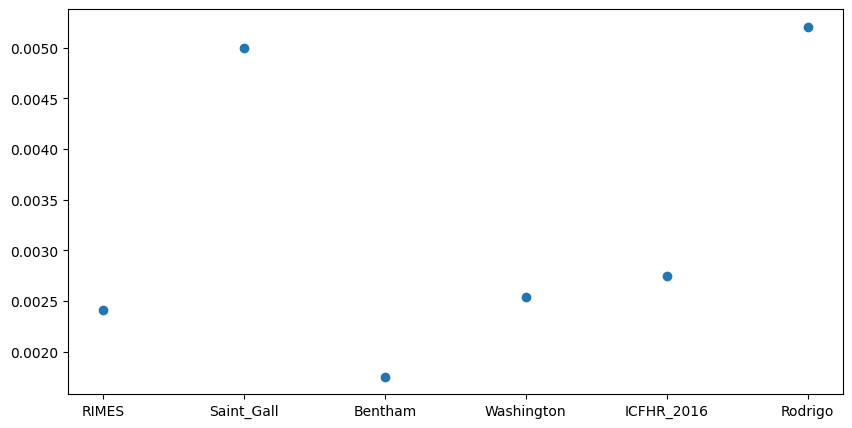

In [27]:
# Plot all reconstructions errors
import matplotlib.pyplot as plt

datasets = list(reconstruction_errors.keys())
reconstruction_error_values = [reconstruction_errors[dataset]["reconstruction_error"] for dataset in datasets]

plt.figure(figsize=(10, 5))
plt.scatter(datasets[1:], reconstruction_error_values[1:])

In [28]:
# Get triplets for recontruction errors and perplexity for each dataset

# results for crnn_puig for cer
test_cer_bentham = round(0.2528873085975647 * 100, 2)
test_cer_iam = round(0.06377743184566498 * 100, 2)
test_cer_icfhr_2016 = round(0.8621333837509155 * 100, 2)
test_cer_rimes = round(0.24963143467903137 * 100, 2)
test_cer_rodrigo = round(0.4092823266983032 * 100, 2)
test_cer_saint_gall = round(0.45431503653526306 * 100, 2)
test_cer_washington = round(0.3105919063091278 * 100, 2)

triples_results_crnn_puig = dict()
triples_results_crnn_puig["IAM"] = (reconstruction_errors["IAM"]["reconstruction_error"], (total_ppl_iam/len(dl_iam_test)).cpu().numpy(), test_cer_iam)
triples_results_crnn_puig["RIMES"] = (reconstruction_errors["RIMES"]["reconstruction_error"], (total_ppl_rimes/len(dl_rimes_test)).cpu().numpy(), test_cer_rimes)
triples_results_crnn_puig["Saint_Gall"] = (reconstruction_errors["Saint_Gall"]["reconstruction_error"], (total_ppl_saint_gall/len(dl_saint_gall_test)).cpu().numpy(), test_cer_saint_gall)
triples_results_crnn_puig["Bentham"] = (reconstruction_errors["Bentham"]["reconstruction_error"], (total_ppl_bentham/len(dl_bentham_test)).cpu().numpy(), test_cer_bentham)
triples_results_crnn_puig["Washington"] = (reconstruction_errors["Washington"]["reconstruction_error"], (total_ppl_washington/len(dl_washington_test)).cpu().numpy(), test_cer_washington)
triples_results_crnn_puig["ICFHR_2016"] = (reconstruction_errors["ICFHR_2016"]["reconstruction_error"], (total_ppl_icfhr_2016/len(dl_icfhr_2016_test)).cpu().numpy(), test_cer_icfhr_2016)
triples_results_crnn_puig["Rodrigo"] = (reconstruction_errors["Rodrigo"]["reconstruction_error"], (total_ppl_rodrigo/len(dl_rodrigo_test)).cpu().numpy(), test_cer_rodrigo)

triples_results_crnn_puig

{'IAM': (0.0028484346731653754, array(7.4604044, dtype=float32), 6.38),
 'RIMES': (0.0024058964333298276, array(40.941715, dtype=float32), 24.96),
 'Saint_Gall': (0.004999884126294283, array(66.99635, dtype=float32), 45.43),
 'Bentham': (0.0017529360906675805, array(9.069226, dtype=float32), 25.29),
 'Washington': (0.002542416685106564, array(9.620369, dtype=float32), 31.06),
 'ICFHR_2016': (0.002749512523189466, array(116.38477, dtype=float32), 86.21),
 'Rodrigo': (0.005206573418454972, array(109.62202, dtype=float32), 40.93)}

In [29]:
# Fit a linear regression model to predict the cer from the reconstruction error and the perplexity

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = np.array([[v[0], v[1]] for v in triples_results_crnn_puig.values()])
y = np.array([v[2] for v in triples_results_crnn_puig.values()])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=42)
X_train, y_train = X, y

# reg = LinearRegression().fit(X_train, y_train)
reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train, y_train))
print(reg.coef_)


0.7805486485498481
[-8.14322140e+03  5.68042089e-01]


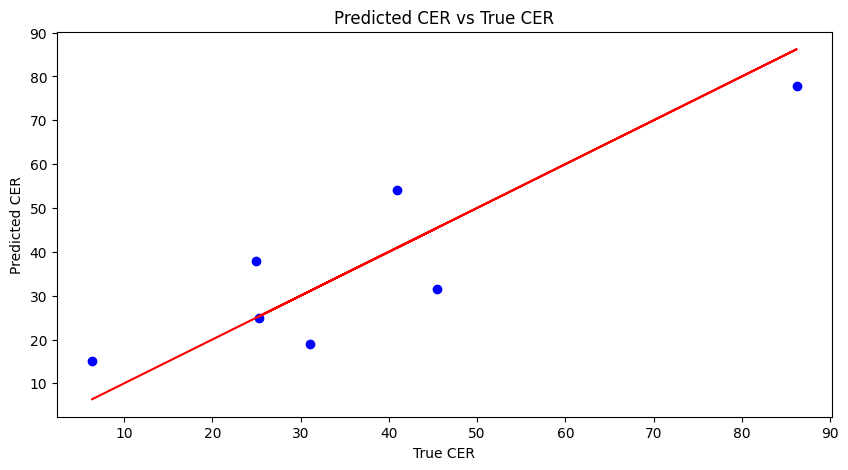

In [30]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.scatter(y_train, reg.predict(X_train), color="blue")
plt.plot(y_train, y_train, color="red")

plt.xlabel("True CER")
plt.ylabel("Predicted CER")
plt.title("Predicted CER vs True CER")

plt.show()


In [31]:
# Get triplets for recontruction errors and perplexity for each dataset

# results for van_coquenet for cer
test_cer_bentham = round(0.26222336292266846 * 100, 2)
test_cer_iam = round(0.0647944584488868 * 100, 2)
test_cer_icfhr_2016 = round(0.853795289993286 * 100, 2)
test_cer_rimes = round(0.2122079879045486 * 100, 2)
test_cer_rodrigo = round(0.3787307441234588 * 100, 2)
test_cer_saint_gall = round(0.387421429157257 * 100, 2)
test_cer_washington = round(0.333489090204238 * 100, 2)

triples_results_van_coquenet = dict()
triples_results_van_coquenet["IAM"] = (reconstruction_errors["IAM"]["reconstruction_error"], (total_ppl_iam/len(dl_iam_test)).cpu().numpy(), test_cer_iam)
triples_results_van_coquenet["RIMES"] = (reconstruction_errors["RIMES"]["reconstruction_error"], (total_ppl_rimes/len(dl_rimes_test)).cpu().numpy(), test_cer_rimes)
triples_results_van_coquenet["Saint_Gall"] = (reconstruction_errors["Saint_Gall"]["reconstruction_error"], (total_ppl_saint_gall/len(dl_saint_gall_test)).cpu().numpy(), test_cer_saint_gall)
triples_results_van_coquenet["Bentham"] = (reconstruction_errors["Bentham"]["reconstruction_error"], (total_ppl_bentham/len(dl_bentham_test)).cpu().numpy(), test_cer_bentham)
triples_results_van_coquenet["Washington"] = (reconstruction_errors["Washington"]["reconstruction_error"], (total_ppl_washington/len(dl_washington_test)).cpu().numpy(), test_cer_washington)
triples_results_van_coquenet["ICFHR_2016"] = (reconstruction_errors["ICFHR_2016"]["reconstruction_error"], (total_ppl_icfhr_2016/len(dl_icfhr_2016_test)).cpu().numpy(), test_cer_icfhr_2016)
triples_results_van_coquenet["Rodrigo"] = (reconstruction_errors["Rodrigo"]["reconstruction_error"], (total_ppl_rodrigo/len(dl_rodrigo_test)).cpu().numpy(), test_cer_rodrigo)

triples_results_van_coquenet

{'IAM': (0.0028484346731653754, array(7.4604044, dtype=float32), 6.48),
 'RIMES': (0.0024058964333298276, array(40.941715, dtype=float32), 21.22),
 'Saint_Gall': (0.004999884126294283, array(66.99635, dtype=float32), 38.74),
 'Bentham': (0.0017529360906675805, array(9.069226, dtype=float32), 26.22),
 'Washington': (0.002542416685106564, array(9.620369, dtype=float32), 33.35),
 'ICFHR_2016': (0.002749512523189466, array(116.38477, dtype=float32), 85.38),
 'Rodrigo': (0.005206573418454972, array(109.62202, dtype=float32), 37.87)}

In [32]:
# Fit a linear regression model to predict the cer from the reconstruction error and the perplexity

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = np.array([[v[0], v[1]] for v in triples_results_van_coquenet.values()])
y = np.array([v[2] for v in triples_results_van_coquenet.values()])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=42)
X_train, y_train = X, y

# reg = LinearRegression().fit(X_train, y_train)
reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train, y_train))
print(reg.coef_)


0.7571121953241918
[-9.61963778e+03  5.60633443e-01]


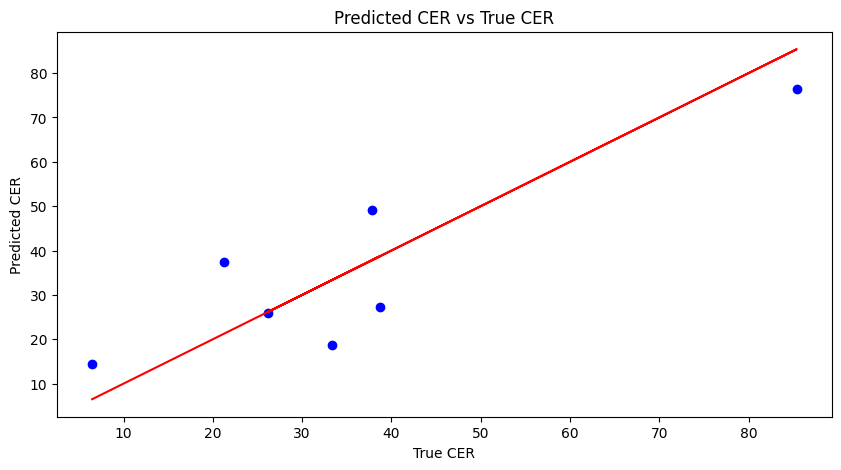

In [33]:
# plot the data for van_coquenet and crnn_puig

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.scatter(y_train, reg.predict(X_train), color="blue")
plt.plot(y_train, y_train, color="red")

plt.xlabel("True CER")
plt.ylabel("Predicted CER")
plt.title("Predicted CER vs True CER")

plt.show()


0.7661601347519842
[-8.88142959e+03  5.64337766e-01]


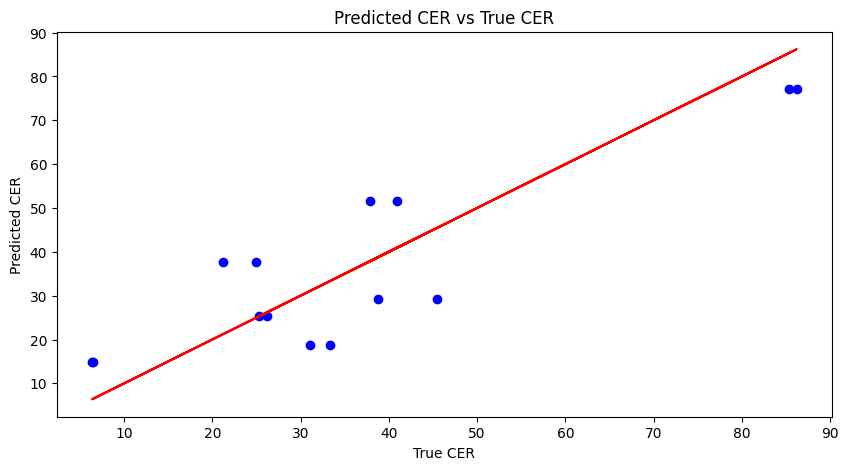

In [34]:
# Fit a linear regression model to predict the cer from the reconstruction error and the perplexity for all models

import numpy as np

triples_results = dict()

triples_results["crnn_puig"] = triples_results_crnn_puig
triples_results["van_coquenet"] = triples_results_van_coquenet

X = np.array([[v[0], v[1]] for v in triples_results["crnn_puig"].values()])
# Add the values for van_coquenet
X = np.vstack([X, np.array([[v[0], v[1]] for v in triples_results["van_coquenet"].values()])])

y = np.array([v[2] for v in triples_results["crnn_puig"].values()])
# Add the values for van_coquenet
y = np.hstack([y, np.array([v[2] for v in triples_results["van_coquenet"].values()])])

X_train, y_train = X, y

reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train, y_train))
print(reg.coef_)

# plot the data for van_coquenet and crnn_puig

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.scatter(y_train, reg.predict(X_train), color="blue")
plt.plot(y_train, y_train, color="red")

plt.xlabel("True CER")
plt.ylabel("Predicted CER")
plt.title("Predicted CER vs True CER")

plt.show()
 